In [1]:
#!pip install fasttext
!rm -rf ReST/
!git clone https://github.com/alessandrocuda/ReSt
!wget http://www.italianlp.it/twitter128.bin

Cloning into 'ReSt'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 134 (delta 4), reused 29 (delta 2), pack-reused 87
Receiving objects: 100% (134/134), 79.56 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (69/69), done.
--2021-03-12 13:04:17--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  27.1MB/s    in 25s     

2021-03-12 13:04:43 (23.5 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [2]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
root_project = "/content/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/ReSt/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb

%load_ext autoreload
%autoreload 2

In [3]:
print(tf.__version__)

2.4.1


# Path

In [4]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
w2v_bin_path               = "/content/twitter128.bin"
#w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

# Embedding

In [5]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


# DATA

In [6]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [7]:
def load_data(dataset_dict, w2v, key_to_index, embedding_matrix, max_text_len):
    #TODO: deve ritornare anche tutto il resto, extra, lemma, stem, ...
    senteces = dataset_dict["tokens"]
    X = dataset_dict["tokens"]
    X = set_unkmark_token(X, w2v)
    X = get_int_seq(X, key_to_index)
    X = pad_sequences(X, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
    X = np.array(X)
    y = np.array(dataset_dict["stereotype"])
    return X, y

def to_emb(X):
    return np.array([ [ embedding_matrix[index_word] for index_word in sentence] for sentence in X])

In [16]:
#load dev/test
MAX_TEXT_LEN = 65

X, y = load_data(dataset_dev, w2v, key_to_index,embedding_matrix, MAX_TEXT_LEN)
X_e = to_emb(X)
X_test, y_test = load_data(dataset_test_tweets, w2v, key_to_index, embedding_matrix, MAX_TEXT_LEN)
X_test_e = to_emb(X_test)

# Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_e, y, test_size=0.10, random_state=128)

# Metrics

In [10]:
def f1_sklean_mapping_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def f1_macro(y_true, y_pred):
    return tf.py_function(f1_sklean_mapping_macro, (y_true, K.round(y_pred)), tf.double)

# callback

In [11]:
class FCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, validation = (), verbose = 0):
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.val_f1 = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0]) > 0.5, 1, 0)
        logs['val_f1'] =  f1_score(y_t, y_p, average='macro')
        if self.verbose >0:
            print("— val_f1: {}".format(logs['val_f1']))

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# KIM-CNN

In [26]:
def kim_cnn(print_model=False):
    """ HyperParameters """
    FILTERS = 256
    output_dims = 1
    hidden_dims= 1

    text_seq_input = Input(shape=(MAX_TEXT_LEN, WORD_EMB_SIZE,), name="text")
    #text_embedding = Embedding(VOCAB_SIZE, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
    #                           weights=[embedding_matrix], trainable=False)(text_seq_input)

    filter_sizes = [2,4,6]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size)(text_seq_input)
        l_bn   = BatchNormalization()(l_conv)
        l_relu = Activation("relu")(l_bn)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    # since the text is too long we are maxooling over 100
    # and not GlobalMaxPool1D
    l_flat = Flatten()(l_merge)
    l_hidden = Dense(256, activation='relu')(l_flat)
    l = Dropout(0.5)(l_hidden)
    l_hidden = Dense(128, activation='relu')(l)
    l = Dropout(0.5)(l_hidden)
    l_out_st = Dense(1, activation='sigmoid', name="st")(l)  #dims output

    model_cnn = Model(inputs=text_seq_input, outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    return model_cnn

In [27]:
#del model
model = kim_cnn(True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 65, 128)]    0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 64, 256)      65792       text[0][0]                       
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 62, 256)      131328      text[0][0]                       
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 60, 256)      196864      text[0][0]                       
____________________________________________________________________________________________

In [ ]:
model.compile(
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.07, momentum=0, nesterov=False),
    metrics=[f1_macro]
)
#mc = ModelCheckpoint('best_model.h5', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
#es = EarlyStopping(monitor="val_f1_macro", min_delta=0, patience=200, verbose=1, mode="max", restore_best_weights=False)
f1_callback = FCallback(validation = (X_test_e, y_test), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1_macro", min_delta=0, patience=100, verbose=1, mode="max", restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val), callbacks=[f1_callback, best_callback], verbose = 1)
#model_cnn = load_model('best_model.h5', custom_objects={'f1_macro': f1_macro})

In [32]:
y_val_pred = np.where(model.predict(X_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.7202573793132983
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       369
           1       0.68      0.74      0.71       315

    accuracy                           0.72       684
   macro avg       0.72      0.72      0.72       684
weighted avg       0.72      0.72      0.72       684



In [34]:
y_test_pred = np.where(model.predict(X_test_e) > 0.5, 1, 0)
print(y_test.shape)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

(1263,)
0.6855554991148212
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       694
           1       0.63      0.74      0.68       569

    accuracy                           0.69      1263
   macro avg       0.69      0.69      0.69      1263
weighted avg       0.70      0.69      0.69      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'f1_macro', 'val_loss', 'val_f1_macro', 'val_f1'])


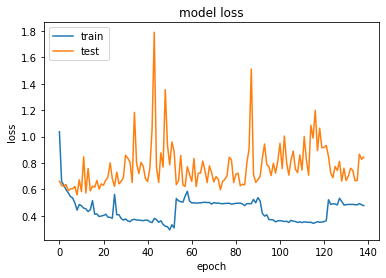

In [29]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ensemble predictions

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
cv_kfold = StratifiedKFold(n_splits=5, shuffle=True)

models = []
X = X_train
X_extra = X_train2
y = y_train
test   = {"text": X_val, "extra": X_val2}

y_test = y_val

for train_index, test_index in cv_kfold.split(X, y):
  model = build_model()
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      #optimizer=tf.keras.optimizers.Adam(learning_rate=0.007, amsgrad=True),
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.4, nesterov=True),
      metrics=["accuracy"]
  )
  input_train = {"text": X[train_index], "extra": X_extra[train_index]}
  input_val   = {"text": X[test_index], "extra": X_extra[test_index]}
  y_train = y[train_index]
  y_val = y[test_index]
  f1_callback1 = ROCCallback(validation = (input_val, y_val), verbose = 0)                                   
  best_callback1 = ReturnBestEarlyStopping(monitor="val_f1",
                                          min_delta=0,
                                          patience=200,
                                          verbose=0,
                                          mode="max",
                                          #baseline=0.72,
                                          restore_best_weights=True)
  model.fit(input_train, y_train, batch_size=128, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback1, best_callback1], verbose=0)
  y_test_pred = np.where(model.predict(test) >0.5,1,0)
  print(f1_score(y_test,y_test_pred,average="macro"))
  models.append(model)


0.7020388105758069
0.7397104473272389
0.7321598940789346
0.7251979246114018
0.7258058638290028


In [ ]:
def ensemble_predictions(members, testX):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(test) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [ ]:
y_pred = ensemble_predictions(models, test)
print(classification_report(y_test,y_pred))


(5, 684)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       370
           1       0.67      0.70      0.68       314

    accuracy                           0.70       684
   macro avg       0.70      0.70      0.70       684
weighted avg       0.70      0.70      0.70       684

